In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive')
!pwd

/content/drive/My Drive


In [ ]:
%tensorflow_version

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


In [ ]:
import pandas as pd
import numpy as np
from tqdm import trange


from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from keras import regularizers
import keras
from keras import optimizers
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate
from keras.layers.advanced_activations import ReLU
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
import random
import math
import matplotlib.image as mpimg
import cv2
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras import callbacks
from keras import layers, models

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

from google.colab.patches import cv2_imshow

In [ ]:
IMG_WIDTH=256
IMG_HEIGHT=256

In [ ]:
def create_dataset(path):
  img_data_array = []

  for i in trange(1, 4126):
            
        path2 = "img"+ str(i) +".jpg"
        path1 = os.path.join(path, path2)
        # print(path1)
        image= cv2.imread(path1, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, (224, 224),interpolation = cv2.INTER_AREA)
        # cv2_imshow(image)
        image=np.array(image)
        image = image.astype('float32')
        image /= 255 
        img_data_array.append(image)
      
        # print(image)

  return img_data_array


# extract the image array and class name
img_data=create_dataset('10psi-images')     #check if the images are mapped correctly to labels

100%|██████████| 4125/4125 [20:11<00:00,  3.40it/s]


In [ ]:
train_data = np.asarray(img_data)
train_data.shape

(4125, 224, 224, 3)

In [ ]:
y_train = pd.read_csv('10psi-labels-all.csv')

In [ ]:
num_classes = 5

In [ ]:
train_data.shape

(4125, 224, 224, 3)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_data, y_train, test_size = 0.3, random_state=600, shuffle=True)

In [ ]:
print(y_train)

       B   R  Theta   X   Y
2317  18  10    -20  16  18
443   22  12    -10  16  16
692   20  10     10  16  16
2739  30   4     20  16  18
2649  22  24     20  16  18
...   ..  ..    ...  ..  ..
410   20  -4    -10  16  16
2506  12 -12     20  16  18
3375  16 -24     10  18  16
954   20 -16    -20  16  16
3275  30 -24    -10  18  16

[2887 rows x 5 columns]


In [ ]:
input_shape = (224, 224, 3)

In [ ]:
maxb = y_train.iloc[:,0].max()
minb = y_train.iloc[:,0].min()

maxr = y_train.iloc[:,1].max()       #finding the min and max of r, x, y columns in the train data
minr = y_train.iloc[:,1].min()

maxt = y_train.iloc[:,2].max()
mint = y_train.iloc[:,2].min()

maxx = y_train.iloc[:,3].max()
minx = y_train.iloc[:,3].min()

maxy = y_train.iloc[:,4].max()
miny = y_train.iloc[:,4].min()


In [ ]:
print(maxb, minb, maxr, minr, maxt, mint, maxx, minx, maxy, miny)

30 10 24 -24 20 -20 18 16 18 16


In [ ]:
y_train_scaled = y_train      #creating another variable y_train_scaled where i copy y_train
y_train_scaled

,B,R,Theta,X,Y
2317,18,10,-20,16,18
443,22,12,-10,16,16
692,20,10,10,16,16
2739,30,4,20,16,18
2649,22,24,20,16,18
...,...,...,...,...,...
410,20,-4,-10,16,16
2506,12,-12,20,16,18
3375,16,-24,10,18,16
954,20,-16,-20,16,16


In [ ]:
for i in range(len(y_train_scaled.iloc[:,0])):    #scaling 
  y_train_scaled.iloc[i,0] = (2 *(y_train_scaled.iloc[i,0] - minb)/(maxb-minb)) - 1   #

for i in range(len(y_train_scaled.iloc[:,1])):    #scaling 
  y_train_scaled.iloc[i,1] = (2 *(y_train_scaled.iloc[i,1] - minr)/(maxr-minr)) - 1   #

for i in range(len(y_train_scaled.iloc[:,2])):    #scaling 
  y_train_scaled.iloc[i,2] = (2 *(y_train_scaled.iloc[i,2] - mint)/(maxt-mint)) - 1   #

for i in range(len(y_train_scaled.iloc[:,3])):    #scaling 
  y_train_scaled.iloc[i,3] = (2 *(y_train_scaled.iloc[i,3] - minx)/(maxx-minx)) - 1   #

for i in range(len(y_train_scaled.iloc[:,4])):    #scaling 
  y_train_scaled.iloc[i,4] = (2 *(y_train_scaled.iloc[i,4] - miny)/(maxy-miny)) - 1   #


In [ ]:
y_train_scaled

,B,R,Theta,X,Y
2317,-0.2,0.416667,-1.0,-1.0,1.0
443,0.2,0.500000,-0.5,-1.0,-1.0
692,0.0,0.416667,0.5,-1.0,-1.0
2739,1.0,0.166667,1.0,-1.0,1.0
2649,0.2,1.000000,1.0,-1.0,1.0
...,...,...,...,...,...
410,0.0,-0.166667,-0.5,-1.0,-1.0
2506,-0.8,-0.500000,1.0,-1.0,1.0
3375,-0.4,-1.000000,0.5,1.0,-1.0
954,0.0,-0.666667,-1.0,-1.0,-1.0


In [ ]:
maxb = y_test.iloc[:,0].max()
minb = y_test.iloc[:,0].min()

maxr = y_test.iloc[:,1].max()       #finding the min and max of r, x, y columns in the test data
minr = y_test.iloc[:,1].min()

maxt = y_test.iloc[:,2].max()
mint = y_test.iloc[:,2].min()

maxx = y_test.iloc[:,3].max()
minx = y_test.iloc[:,3].min()

maxy = y_test.iloc[:,4].max()
miny = y_test.iloc[:,4].min()


In [ ]:
print(maxb, minb, maxr, minr, maxt, mint, maxx, minx, maxy, miny)

30 10 24 -24 20 -20 18 16 18 16


In [ ]:
y_test_scaled = y_test
y_test_scaled

,B,R,Theta,X,Y
2893,20,12,0,18,16
3055,12,-14,-10,18,16
2155,28,-14,10,16,18
481,26,-12,-10,16,16
665,18,6,10,16,16
...,...,...,...,...,...
3874,10,24,20,18,16
3552,30,-20,10,18,16
619,14,14,10,16,16
539,30,4,-10,16,16


In [ ]:
for i in range(len(y_test_scaled.iloc[:,0])):    #scaling 
  y_test_scaled.iloc[i,0] = (2 *(y_test_scaled.iloc[i,0] - minb)/(maxb-minb)) - 1   #

for i in range(len(y_test_scaled.iloc[:,1])):    #scaling 
  y_test_scaled.iloc[i,1] = (2 *(y_test_scaled.iloc[i,1] - minr)/(maxr-minr)) - 1   #

for i in range(len(y_test_scaled.iloc[:,2])):    #scaling 
  y_test_scaled.iloc[i,2] = (2 *(y_test_scaled.iloc[i,2] - mint)/(maxt-mint)) - 1   #

for i in range(len(y_test_scaled.iloc[:,3])):    #scaling 
  y_test_scaled.iloc[i,3] = (2 *(y_test_scaled.iloc[i,3] - minx)/(maxx-minx)) - 1   #

for i in range(len(y_test_scaled.iloc[:,4])):    #scaling 
  y_test_scaled.iloc[i,4] = (2 *(y_test_scaled.iloc[i,4] - miny)/(maxy-miny)) - 1   #


In [ ]:
new_input = Input(shape=(224, 224, 3))
vgg_model = VGG16(include_top=False, weights='imagenet', input_tensor=new_input)

for layer in vgg_model.layers[:15]:
  layer.trainable = False


for layer in vgg_model.layers:
    print(layer, layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x7f686e4d3bd0> False
<keras.layers.convolutional.Conv2D object at 0x7f686e8af5d0> False
<keras.layers.convolutional.Conv2D object at 0x7f685c2e6dd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f685c27b810> False
<keras.layers.convolutional.Conv2D object at 0x7f686e4aec50> False
<keras.layers.convolutional.Conv2D object at 0x7f685c289090> False
<keras.layers.pooling.MaxPooling2D object at 0x7f686e3e5710> False
<keras.layers.convolutional.Conv2D object at 0x7f685c27ba90> False
<keras.layers.convolutional.Conv2D object at 0x7f685c24b710> False
<keras.layers.convolutional.Conv2D object at 0x7f686ef72810> False
<keras.layers.pooling.MaxPooling2D object at 0x7f685c3253d0> False
<keras.layers.convolutional.Conv2D object at 0x7f67bc4021d0> False
<keras.layers.convolutional.Conv2D object at 0x7f685c25acd0> False
<keras.layers.convolutional.Conv2D object at 0x7f6880099b10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f685c13f850>

In [ ]:
def create_model():
  model = Sequential()
  model.add(vgg_model)

  model.add(layers.Flatten())
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0005)))
  model.add(layers.Dropout(0.4))
  
  model.add(layers.BatchNormalization())
  
  model.add(layers.Dense(5, activation='tanh', kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0005)))
  model.add(layers.Dropout(0.4) )  # L1 + L2 penalties
  model.compile(optimizer= Adam(0.00005), # adam
              loss='mean_squared_error',
              metrics=['mse'])

  return model


In [ ]:
# def create_model():
#   model = Sequential()
#   model.add(vgg_model)
#   model.add(layers.Flatten())
#   model.add(layers.BatchNormalization())
#   model.add(layers.Dense(64, activation='relu'))
#   model.add(layers.Dropout(0.25))
#   model.add(layers.BatchNormalization())
#   model.add(layers.Dense(3, activation='tanh'))
#   model.add(layers.Dropout(0.25))
#   model.compile(optimizer= Adam(0.0003),#"adam",
#               loss='mean_squared_error',
#               metrics=['mse'])
#   return model


In [ ]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 25088)             100352    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                

In [ ]:
'''
initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs  
def lr_time_based_decay(epoch, lr):
  red_lr = 0.0001
  if epoch < 20:  
    lr = 0.01

  else:
    lr = red_lr * 1 / (1 + decay * epoch)

  return lr
'''

'\ninitial_learning_rate = 0.01\nepochs = 100\ndecay = initial_learning_rate / epochs  \ndef lr_time_based_decay(epoch, lr):\n  red_lr = 0.0001\n  if epoch < 20:  \n    lr = 0.01\n\n  else:\n    lr = red_lr * 1 / (1 + decay * epoch)\n\n  return lr\n'

In [ ]:
initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [ ]:
history = model.fit(x_train, y_train_scaled,
          epochs=150,
          batch_size = 128,
          validation_split=0.3,
          callbacks=[callbacks.LearningRateScheduler(lr_time_based_decay, verbose=1)],
          verbose=1)

Epoch 1/150

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
16/16 [==============================] - 15s 823ms/step - loss: 2.6995 - mse: 1.3933 - val_loss: 2.1425 - val_mse: 0.8569
Epoch 2/150

Epoch 00002: LearningRateScheduler reducing learning rate to 4.999499923697006e-05.
16/16 [==============================] - 12s 789ms/step - loss: 2.4890 - mse: 1.2087 - val_loss: 2.0321 - val_mse: 0.7672
Epoch 3/150

Epoch 00003: LearningRateScheduler reducing learning rate to 4.998500315338214e-05.
16/16 [==============================] - 13s 797ms/step - loss: 2.3389 - mse: 1.0786 - val_loss: 1.9551 - val_mse: 0.7085
Epoch 4/150

Epoch 00004: LearningRateScheduler reducing learning rate to 4.9970011984655534e-05.
16/16 [==============================] - 13s 809ms/step - loss: 2.2023 - mse: 0.9599 - val_loss: 1.9135 - val_mse: 0.6834
Epoch 5/150

Epoch 00005: LearningRateScheduler reducing learning rate to 4.9950030865240805e-05.
16/16 [==================

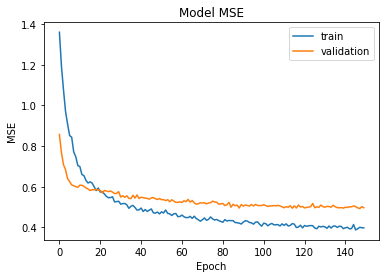

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

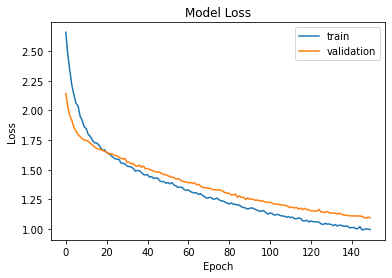

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
# initial_learning_rate = 0.0001
# epochs = 100
# decay = initial_learning_rate / epochs
# def lr_time_based_decay(epoch, lr):
#     lr = lr * 1 / (1 + decay * epoch)
#     return lr


In [ ]:
# history = model.fit(x_train, y_train_scaled,
#           epochs=100,
#           batch_size = 128,
#           validation_split=0.3,
#           callbacks=[callbacks.LearningRateScheduler(lr_time_based_decay, verbose=1)],
#           verbose=1)

In [ ]:
for i in range(len(y_test_scaled.iloc[:,0])):     #unscaling y_test_scaled back to original distribution
  # print(i)
  y_test_scaled.iloc[i,0] = ((y_test_scaled.iloc[i,0] + 1)*(maxb-minb))/2 + minb


for i in range(len(y_test_scaled.iloc[:,1])):
  # print(i)
  y_test_scaled.iloc[i,1] = ((y_test_scaled.iloc[i,1] + 1)*(maxr-minr))/2 + minr   #

for i in range(len(y_test_scaled.iloc[:,2])):
  # print(i)
  y_test_scaled.iloc[i,2] = ((y_test_scaled.iloc[i,2] + 1)*(maxt-mint))/2 + mint 

for i in range(len(y_test_scaled.iloc[:,3])):
  # print(i)
  y_test_scaled.iloc[i,3] = ((y_test_scaled.iloc[i,3] + 1)*(maxx-minx))/2 + minx   #

for i in range(len(y_test_scaled.iloc[:,4])):
  # print(i)
  y_test_scaled.iloc[i,4] = ((y_test_scaled.iloc[i,4] + 1)*(maxy-miny))/2 + miny 

In [ ]:
y_test_scaled

,B,R,Theta,X,Y
2893,2220.0,6912.0,0.0,52.0,50.0
3055,1420.0,-8064.0,-4000.0,52.0,50.0
2155,3020.0,-8064.0,4000.0,50.0,52.0
481,2820.0,-6912.0,-4000.0,50.0,50.0
665,2020.0,3456.0,4000.0,50.0,50.0
...,...,...,...,...,...
3874,1220.0,13824.0,8000.0,52.0,50.0
3552,3220.0,-11520.0,4000.0,52.0,50.0
619,1620.0,8064.0,4000.0,50.0,50.0
539,3220.0,2304.0,-4000.0,50.0,50.0


In [ ]:
prediction = model.predict(x_test)    #finding predictions on x_test

## Prediction

In [ ]:
for i in range(len(prediction[:,0])):     #unscaling prediction back to original distribution
  # print(i)
  prediction[i,0] = ((prediction[i,0] + 1)*(maxb-minb))/2 + minb


for i in range(len(prediction[:,1])):
  # print(i)
  prediction[i,1] = ((prediction[i,1] + 1)*(maxr-minr))/2 + minr   #

for i in range(len(prediction[:,2])):
  # print(i)
  prediction[i,2] = ((prediction[i,2] + 1)*(maxt-mint))/2 + mint 

for i in range(len(prediction[:,3])):
  # print(i)
  prediction[i,3] = ((prediction[i,3] + 1)*(maxx-minx))/2 + minx   #

for i in range(len(prediction[:,4])):
  # print(i)
  prediction[i,4] = ((prediction[i,4] + 1)*(maxy-miny))/2 + miny 

In [ ]:
prediction

array([[ 18.704205 ,   8.268025 ,   6.6444325,  17.379068 ,  16.510143 ],
       [ 20.17179  ,   1.351907 , -19.947721 ,  16.17385  ,  16.013565 ],
       [ 18.147415 ,   2.2511263,  -3.1462283,  16.436237 ,  17.610424 ],
       ...,
       [ 17.869741 ,   7.73464  ,   1.8196359,  16.623913 ,  16.534464 ],
       [ 22.0707   ,   0.2343053,  -4.8081083,  16.716135 ,  16.484648 ],
       [ 20.015505 ,   8.783417 ,   6.0361223,  16.76498  ,  17.418926 ]],
      dtype=float32)

In [ ]:
prediction_round = np.rint(prediction)

In [ ]:
prediction_round

array([[ 19.,   8.,   7.,  17.,  17.],
       [ 20.,   1., -20.,  16.,  16.],
       [ 18.,   2.,  -3.,  16.,  18.],
       ...,
       [ 18.,   8.,   2.,  17.,  17.],
       [ 22.,   0.,  -5.,  17.,  16.],
       [ 20.,   9.,   6.,  17.,  17.]], dtype=float32)

In [ ]:
y_test_scaled

,B,R,Theta,X,Y
2893,2220.0,6912.0,0.0,52.0,50.0
3055,1420.0,-8064.0,-4000.0,52.0,50.0
2155,3020.0,-8064.0,4000.0,50.0,52.0
481,2820.0,-6912.0,-4000.0,50.0,50.0
665,2020.0,3456.0,4000.0,50.0,50.0
...,...,...,...,...,...
3874,1220.0,13824.0,8000.0,52.0,50.0
3552,3220.0,-11520.0,4000.0,52.0,50.0
619,1620.0,8064.0,4000.0,50.0,50.0
539,3220.0,2304.0,-4000.0,50.0,50.0


In [ ]:
# y_test_inv = target_scaler.inverse_transform(y_test)

In [ ]:
# prediction = model.predict(x_test)
# prediction = target_scaler.inverse_transform(prediction)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
mse = mean_squared_error(y_test_scaled, prediction)
mae = mean_absolute_error(y_test_scaled, prediction)

In [ ]:
print(mse)
print(mae)

20737821.17114968
2816.478427997175


In [ ]:
model.save("absolute-best-model6")

INFO:tensorflow:Assets written to: absolute-best-model4/assets


In [ ]:
model.save("absolute-best-model6.h5")

In [ ]:
# np.savetxt('absolute-best-model3-predictions.csv', prediction_round, delimiter=",")

In [ ]:
# np.savetxt('ground-truth--1to1-rxy.csv', y_test_scaled, delimiter=",")

In [ ]:
# b1 = y_test_inv[:,0]
# b2 = prediction_round[:,0]
# error_b = mean_absolute_error(b1, b2)
# print(error_b)

In [ ]:
# r1 = y_test_scaled.iloc[:,0]
# r2 = prediction_round[:,0]
# error_r = mean_absolute_error(r1, r2)
# print(error_r)

In [ ]:
# t1 = y_test_inv[:,2]
# t2 = prediction_round[:,2]
# error_t = mean_absolute_error(t1, t2)
# print(error_t)

In [ ]:
from keras.models import load_model

In [ ]:
n_members = 3
models = list()

# model1 = load_model('absolute-best-model2.h5')
model2 = load_model('absolute-best-model3.h5')
model3 = load_model('absolute-best-model6.h5')
# model4 = load_model('absolute-best-model5.h5')
	# store in memory
# models.append(model1)
models.append(model2)
models.append(model3)
# models.append(model4)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('img1259.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img= cv2.resize(img, dsize=(224,224), interpolation = cv2.INTER_CUBIC)
# plt.imshow(img)
img.shape

img = np.reshape(img, (1, 224, 224))
# img = np.expand_dims(img, axis = 0)
# img = np.expand_dims(img, axis = 3)
# img = np.reshape(128,128)
# img = img.astype('float32')
img = img/255
img = np.repeat(img[..., np.newaxis], 3, -1)
# plt.imshow(img.reshape(128,128), cmap = plt.cm.binary)

In [ ]:
img.shape

(1, 224, 224, 3)

In [ ]:
img2 = cv2.imread('target_image.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img2= cv2.resize(img2, dsize=(224,224), interpolation = cv2.INTER_CUBIC)
# plt.imshow(img)
img2.shape

img2 = np.reshape(img2, (1, 224, 224))
# img = np.expand_dims(img, axis = 0)
# img = np.expand_dims(img, axis = 3)
# img = np.reshape(128,128)
# img = img.astype('float32')
img2 = img2/255
img2 = np.repeat(img2[..., np.newaxis], 3, -1)
# plt.imshow(img.reshape(128,128), cmap = plt.cm.binary)

In [ ]:
img2.shape

In [ ]:
# predictionimg = model.predict([img,img2])
# predictionimg = np.rint(predictionimg)

In [ ]:
predictionimg = model2.predict(img2)
print(predictionimg)

In [ ]:
targetimg = model2.predict(img)
print(targetimg)

[[-0.00883751 -0.00230948 -0.04072975 -0.45861852 -0.37419677]]


In [ ]:
for i in range(len(predictionimg[:,0])):     #unscaling predictionimg back to original distribution
  # print(i)
  predictionimg[i,0] = ((predictionimg[i,0] + 1)*(maxb-minb))/2 + minb


for i in range(len(predictionimg[:,1])):
  # print(i)
  predictionimg[i,1] = ((predictionimg[i,1] + 1)*(maxr-minr))/2 + minr   #

for i in range(len(predictionimg[:,2])):
  # print(i)
  predictionimg[i,2] = ((predictionimg[i,2] + 1)*(maxt-mint))/2 + mint 

for i in range(len(predictionimg[:,3])):
  # print(i)
  predictionimg[i,3] = ((predictionimg[i,3] + 1)*(maxx-minx))/2 + minx   #

for i in range(len(predictionimg[:,4])):
  # print(i)
  predictionimg[i,4] = ((predictionimg[i,4] + 1)*(maxy-miny))/2 + miny 

In [ ]:
print(predictionimg)

In [ ]:
for i in range(len(targetimg[:,0])):     #unscaling targetimg back to original distribution
  # print(i)
  targetimg[i,0] = ((targetimg[i,0] + 1)*(maxb-minb))/2 + minb


for i in range(len(targetimg[:,1])):
  # print(i)
  targetimg[i,1] = ((targetimg[i,1] + 1)*(maxr-minr))/2 + minr   #

for i in range(len(targetimg[:,2])):
  # print(i)
  targetimg[i,2] = ((targetimg[i,2] + 1)*(maxt-mint))/2 + mint 

for i in range(len(targetimg[:,3])):
  # print(i)
  targetimg[i,3] = ((targetimg[i,3] + 1)*(maxx-minx))/2 + minx   #

for i in range(len(targetimg[:,4])):
  # print(i)
  targetimg[i,4] = ((targetimg[i,4] + 1)*(maxy-miny))/2 + miny 

In [ ]:
print(targetimg)

[[19.911625   -0.05542746 -0.8145951  16.541382   16.625803  ]]


In [ ]:
delta = targetimg - predictionimg
print(delta)

target =  22  -8 20 16 16.   

In [ ]:
predictionimg2 = model3.predict(img2)
print(predictionimg2)

In [ ]:
targetimg2 = model3.predict(img)
print(targetimg2)

[[-0.2067085  -0.00386199  0.16158421 -0.57697517  0.05799635]]


In [ ]:
for i in range(len(predictionimg2[:,0])):     #unscaling predictionimg2 back to original distribution
  # print(i)
  predictionimg2[i,0] = ((predictionimg2[i,0] + 1)*(maxb-minb))/2 + minb


for i in range(len(predictionimg2[:,1])):
  # print(i)
  predictionimg2[i,1] = ((predictionimg2[i,1] + 1)*(maxr-minr))/2 + minr   #

for i in range(len(predictionimg2[:,2])):
  # print(i)
  predictionimg2[i,2] = ((predictionimg2[i,2] + 1)*(maxt-mint))/2 + mint 

for i in range(len(predictionimg2[:,3])):
  # print(i)
  predictionimg2[i,3] = ((predictionimg2[i,3] + 1)*(maxx-minx))/2 + minx   #

for i in range(len(predictionimg2[:,4])):
  # print(i)
  predictionimg2[i,4] = ((predictionimg2[i,4] + 1)*(maxy-miny))/2 + miny 

In [ ]:
print(predictionimg2)

In [ ]:
for i in range(len(targetimg2[:,0])):     #unscaling targetimg2 back to original distribution
  # print(i)
  targetimg2[i,0] = ((targetimg2[i,0] + 1)*(maxb-minb))/2 + minb


for i in range(len(targetimg2[:,1])):
  # print(i)
  targetimg2[i,1] = ((targetimg2[i,1] + 1)*(maxr-minr))/2 + minr   #

for i in range(len(targetimg2[:,2])):
  # print(i)
  targetimg2[i,2] = ((targetimg2[i,2] + 1)*(maxt-mint))/2 + mint 

for i in range(len(targetimg2[:,3])):
  # print(i)
  targetimg2[i,3] = ((targetimg2[i,3] + 1)*(maxx-minx))/2 + minx   #

for i in range(len(targetimg2[:,4])):
  # print(i)
  targetimg2[i,4] = ((targetimg2[i,4] + 1)*(maxy-miny))/2 + miny 

In [ ]:
print(targetimg2)

[[17.932915   -0.09268773  3.2316842  16.423025   17.057997  ]]


In [ ]:
delta = targetimg2 - predictionimg2
print(delta)